## Impor packages

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt

## Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Myskill/dataset/Online Retail Data.csv')
df.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN


## Data Preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461773 entries, 0 to 461772
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      461773 non-null  object 
 1   product_code  461773 non-null  object 
 2   product_name  459055 non-null  object 
 3   quantity      461773 non-null  int64  
 4   order_date    461773 non-null  object 
 5   price         461773 non-null  float64
 6   customer_id   360853 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 24.7+ MB


In [ ]:
df.describe()

,quantity,price,customer_id
count,461773.000000,461773.000000,360853.000000
mean,9.088892,4.569963,15557.611138
std,86.366467,153.411566,1593.728741
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,14210.000000
50%,3.000000,2.100000,15580.000000
75%,10.000000,4.210000,16938.000000
max,10200.000000,25111.090000,18287.000000


## Data cleansing & Transformation

In [ ]:
# new dataframe
df_clean = df.copy()

In [ ]:
# missing value check
df.isnull().sum()

order_id             0
product_code         0
product_name      2718
quantity             0
order_date           0
price                0
customer_id     100920
dtype: int64

In [ ]:
# duplicated value check
df.duplicated().sum()

6479

In [ ]:
# convert order date into datetime
df_clean['order_date'] = df_clean['order_date'].astype('datetime64[ns]')

In [ ]:
# create new kolom year_month
df_clean['year_month'] = df_clean['order_date'].dt.to_period('M')

In [ ]:
# turn product_name into lowercase
df_clean['product_name'] = df_clean['product_name'].str.lower()

In [ ]:
# create a column 'order_status' with the value 'cancelled' if the order_id starts with the letter 'C'
# and 'delivered' if the order_id does not start with the letter 'C'.
df_clean['order_status'] = np.where(df_clean['order_id'].str[:1]=='C', 'cancelled', 'delivered')

In [ ]:
# transform customer_id into string
df_clean['customer_id'] = df_clean['customer_id'].astype(str)

In [ ]:
# convert negative quantity values to positive
# negative values indicate that the order is cancelled
df_clean['quantity'] = df_clean['quantity'].abs()

In [ ]:
# replacing the product_name from the product_code that has multiple product_names with the most frequently appearing product_name
most_freq_product_name = df_clean.groupby(['product_code','product_name'], as_index=False).agg(order_cnt=('order_id','nunique')).sort_values(['product_code','order_cnt'], ascending=[True,False])
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_code')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank']==1].drop(columns=['order_cnt','rank'])
df_clean = df_clean.merge(most_freq_product_name.rename(columns={'product_name':'most_freq_product_name'}), how='left', on='product_code')
df_clean['product_name'] = df_clean['most_freq_product_name']
df_clean = df_clean.drop(columns='most_freq_product_name')

### Missing value handling

In [ ]:
# percentage missing value, if <1% feel free to drop
data_missing_value = df_clean.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value['percentage'] = round((data_missing_value['missing_value']/len(df_clean))*100,3)
data_missing_value = data_missing_value.sort_values('percentage', ascending=False).reset_index(drop=True)
data_missing_value = data_missing_value[data_missing_value['percentage']>0]
data_missing_value

,feature,missing_value,percentage
0,product_name,388,0.084


In [ ]:
# handling missing value
missing_col = ['customer_id', 'product_name']
for col in missing_col:
  df_clean.dropna(subset=[col], inplace=True)
        #df_clean = df_clean[~df_clean['customer_id'].isna()] *alternative
        #df_clean = df_clean[~df_clean['product_name'].isna()] *alternative

In [ ]:
# delete product_code or product_name test
df_clean = df_clean[(~df_clean['product_code'].str.lower().str.contains('test')) |
                    (~df_clean['product_name'].str.contains('test '))]

In [ ]:
# delete row with negative value in price
df_clean = df_clean[df_clean['price']>0]

In [ ]:
# create column 'amount = quantity * price'
df_clean['amount'] = df_clean['quantity'] * df_clean['price']

In [ ]:
# delete outlier
from scipy import stats
df_clean = df_clean[(np.abs(stats.zscore(df_clean[['quantity','amount']]))<3).all(axis=1)]
df_clean = df_clean.reset_index(drop=True)
df_clean.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id,year_month,order_status,amount
0,C493411,21539,red retrospot butter dish,1,2010-01-04 09:43:00,4.25,14590.0,2010-01,cancelled,4.25
1,493413,21724,panda and bunnies sticker sheet,1,2010-01-04 09:54:00,0.85,nan,2010-01,delivered,0.85
2,493413,84578,elephant toy with blue t-shirt,1,2010-01-04 09:54:00,3.75,nan,2010-01,delivered,3.75
3,493413,21723,alphabet hearts sticker sheet,1,2010-01-04 09:54:00,0.85,nan,2010-01,delivered,0.85
4,493414,21844,red retrospot mug,36,2010-01-04 10:28:00,2.55,14590.0,2010-01,delivered,91.80


In [ ]:
# missing value check
data_missing_value = df_clean.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value

,feature,missing_value
0,order_id,0
1,product_code,0
2,product_name,0
3,quantity,0
4,order_date,0
5,price,0
6,customer_id,0
7,year_month,0
8,order_status,0
9,amount,0


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455496 entries, 0 to 455495
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      455496 non-null  object        
 1   product_code  455496 non-null  object        
 2   product_name  455496 non-null  object        
 3   quantity      455496 non-null  int64         
 4   order_date    455496 non-null  datetime64[ns]
 5   price         455496 non-null  float64       
 6   customer_id   455496 non-null  object        
 7   year_month    455496 non-null  period[M]     
 8   order_status  455496 non-null  object        
 9   amount        455496 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5), period[M](1)
memory usage: 34.8+ MB


## Cohort

### User summary transaction every month

In [ ]:
df_month = df_clean.groupby(['customer_id','year_month'], as_index=False).agg(order_cnt=('order_id','nunique'))
df_month.head()

,customer_id,year_month,order_cnt
0,12346.0,2010-01,1
1,12346.0,2010-03,1
2,12346.0,2010-06,2
3,12346.0,2010-10,1
4,12608.0,2010-10,1


### Create cohort column

In [ ]:
df_month['cohort'] = df_month.groupby('customer_id')['year_month'].transform('min')
df_month

,customer_id,year_month,order_cnt,cohort
0,12346.0,2010-01,1,2010-01
1,12346.0,2010-03,1,2010-01
2,12346.0,2010-06,2,2010-01
3,12346.0,2010-10,1,2010-01
4,12608.0,2010-10,1,2010-10
...,...,...,...,...
12059,nan,2010-08,136,2010-01
12060,nan,2010-09,152,2010-01
12061,nan,2010-10,163,2010-01
12062,nan,2010-11,155,2010-01


### Calculate Distance Between ('Year_Month') and ('cohort') and +1

In [ ]:
from operator import attrgetter

df_month['period_num'] = (df_month['year_month'] - df_month['cohort']).apply(attrgetter('n')) + 1
df_month.head()

,customer_id,year_month,order_cnt,cohort,period_num
0,12346.0,2010-01,1,2010-01,1
1,12346.0,2010-03,1,2010-01,3
2,12346.0,2010-06,2,2010-01,6
3,12346.0,2010-10,1,2010-01,10
4,12608.0,2010-10,1,2010-10,1


### Create Pivot Table

In [ ]:
df_cohort_pivot = pd.pivot_table(df_month, index='cohort', columns='period_num', values='customer_id', aggfunc=pd.Series.nunique)
df_cohort_pivot

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,713.0,282.0,335.0,315.0,306.0,305.0,294.0,268.0,286.0,321.0,337.0,251.0
2010-02,461.0,154.0,128.0,161.0,152.0,121.0,119.0,158.0,153.0,166.0,100.0,NaN
2010-03,527.0,146.0,158.0,144.0,139.0,123.0,148.0,185.0,192.0,95.0,NaN,NaN
2010-04,326.0,83.0,76.0,64.0,70.0,80.0,99.0,102.0,51.0,NaN,NaN,NaN
2010-05,275.0,55.0,50.0,52.0,52.0,73.0,67.0,43.0,NaN,NaN,NaN,NaN
2010-06,267.0,53.0,56.0,60.0,64.0,85.0,39.0,NaN,NaN,NaN,NaN,NaN
2010-07,180.0,38.0,37.0,52.0,53.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,160.0,35.0,50.0,48.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,226.0,63.0,60.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  Calculate the number of users in each cohort (users who made their first transaction in that month) and divide all values in the pivot table by that value as the retention rate

In [ ]:
cohort_size = df_cohort_pivot.iloc[:, 0]
cohort_size

cohort
2010-01    713.0
2010-02    461.0
2010-03    527.0
2010-04    326.0
2010-05    275.0
2010-06    267.0
2010-07    180.0
2010-08    160.0
2010-09    226.0
2010-10    364.0
2010-11    328.0
2010-12     66.0
Freq: M, Name: 1, dtype: float64

In [ ]:
df_retention_cohort = df_cohort_pivot.divide(cohort_size, axis=0)
df_retention_cohort

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,1.0,0.395512,0.469846,0.441795,0.429173,0.427770,0.412342,0.375877,0.401122,0.450210,0.472651,0.352034
2010-02,1.0,0.334056,0.277657,0.349241,0.329718,0.262473,0.258134,0.342733,0.331887,0.360087,0.216920,NaN
2010-03,1.0,0.277040,0.299810,0.273245,0.263757,0.233397,0.280835,0.351044,0.364326,0.180266,NaN,NaN
2010-04,1.0,0.254601,0.233129,0.196319,0.214724,0.245399,0.303681,0.312883,0.156442,NaN,NaN,NaN
2010-05,1.0,0.200000,0.181818,0.189091,0.189091,0.265455,0.243636,0.156364,NaN,NaN,NaN,NaN
2010-06,1.0,0.198502,0.209738,0.224719,0.239700,0.318352,0.146067,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.211111,0.205556,0.288889,0.294444,0.166667,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.218750,0.312500,0.300000,0.168750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,1.0,0.278761,0.265487,0.141593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Heatmap

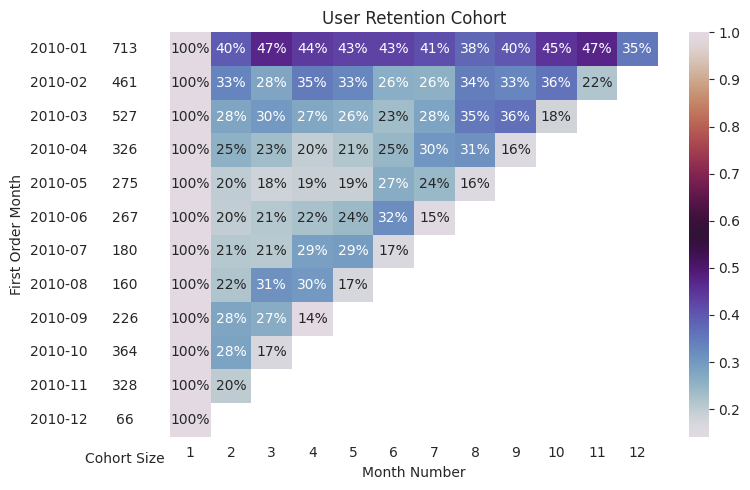

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

with sns.axes_style('white'):

    fig, ax = plt.subplots(1, 2, figsize=(8, 5), sharey=True, gridspec_kw={'width_ratios':[1, 11]})

    # user retention cohort
    sns.heatmap(df_retention_cohort, annot=True, fmt='.0%', cmap='twilight', ax=ax[1]) #(viridis,inferno,pmagma,hot,cividis,twilight)
    ax[1].set_title('User Retention Cohort')
    ax[1].set(xlabel='Month Number', ylabel='')

    # cohort size
    df_cohort_size = pd.DataFrame(cohort_size)
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(df_cohort_size, annot=True, cbar=False, fmt='g', cmap=white_cmap, ax=ax[0])
    ax[0].tick_params(bottom=False)
    ax[0].set(xlabel='Cohort Size', ylabel='First Order Month', xticklabels=[])

    fig.tight_layout()

# Insight
- A total of 713 users constituted the cohort with the highest transaction activity in January, and their activity also peaked in the second month.
- This cohort demonstrates high loyalty with a retention rate averaging above 40%, making them major contributors to transaction volume.
- The majority of users do not return for transactions, as indicated by the cohort retention rate being below 50%.
- December recorded the lowest user transaction volume of the year, reaching less than 23%.